In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_circles, make_blobs
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


# Support Vector Machines (SVMs) - Tutorial - 17.06.2021

## Overview

Hello! This is a practical tutorial. In this notebook, we are going to explore Support Vector Machines (SVMs) hands-on. HINT: There is a comprehensive scikit-learn documentation on SVMs [here](https://scikit-learn.org/stable/modules/svm.html#svm-classification).

The main goals of this notebook are:

- Learn how to use the plug-and-play models implemented in the Python package scikit-learn.
- Explore the power of the parameter `C`.
- Explore the power of different kernels with different parameters `gamma`.

## Datasets
In this notebook we will be using the following three datasets:
- Dataset A: 2-dimensional 2-classes isotropic Gaussian blobs. The samples for each class are generated from a gaussian distribution with a certain mean and standard deviation. This dataset is linearly separable.
- Dataset B: 2-dimensional 2-classes isotropic Gaussian blobs. The samples for each class are generated from a gaussian distribution with a certain mean and standard deviation. This dataset is not linearly separable.
- Dataset C: 2-dimensional 2-classes circles.  Samples for each class are generated from circles with a certain radius plus some noise. This dataset corresponds to a non-liear problem.
- Dataset D: 2-dimensional 3-classes isotropic Gaussian blobs. The samples for each class are generated from a gaussian distribution with a certain mean and standard deviation. This dataset is linearly separable.

In [2]:
# function to plot a dataset
def plot_dataset(X, y, title, axes=None):
      if axes is None:
        axes = plt.gca()
      y_zero = y==0
      y_one = y==1

      axes.scatter(X[y_zero,0],X[y_zero,1],color = "red", label = "Class 0")
      axes.scatter(X[y_one,0],X[y_one,1], color = "blue", label = "Class 1")
      axes.set_title(title)
      axes.set_xlabel("x1")
      axes.set_ylabel("x2")
      axes.legend()
      #plt.show()

In [3]:
# Fix seed
np.random.seed(5)
# Number of training samples
n_samples = 100
# Dataset A
X_blobs1, y_blobs1 = make_blobs(n_samples=n_samples, centers=[(-1, -1), (1, 1)], cluster_std = 0.45)
X_blobs1_test, y_blobs1_test = make_blobs(n_samples=1000, centers=[(-1, -1), (1, 1)], cluster_std = 0.45)
# Dataset B
X_blobs2, y_blobs2 = make_blobs(n_samples=2*n_samples, centers=[(-1, -1), (1, 1)], cluster_std = 0.8)
X_blobs2_test, y_blobs2_test = make_blobs(n_samples=500, centers=[(-1, -1), (1, 1)], cluster_std = 0.8)
# Dataset C
X_circles, y_circles = make_circles(n_samples=n_samples,factor=.1, noise=.05)
X_circles_test, y_circles_test = make_circles(n_samples=500,factor=.1, noise=.05)
# Dataset D
X_blobs3, y_blobs3 = make_blobs(n_samples=n_samples, centers=[(-1, -1), (1, 1), (2,-1)], cluster_std = 0.5)
X_blobs3_test, y_blobs3_test = make_blobs(n_samples=500, centers=[(-1, -1), (1, 1), (2,-1)], cluster_std = 0.5)

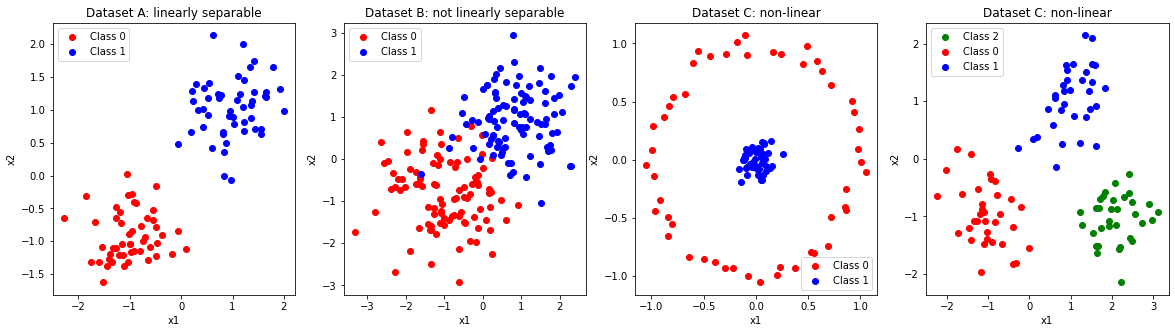

In [4]:
# Ploting the datasets
fig, ax = plt.subplots(1,4, figsize=(20,5))
# 2 classes
plot_dataset(X_blobs1, y_blobs1, title="Dataset A: linearly separable", axes = ax[0])
plot_dataset(X_blobs2, y_blobs2, title="Dataset B: not linearly separable", axes = ax[1])
plot_dataset(X_circles, y_circles, title="Dataset C: non-linear", axes = ax[2])
# 3 classes
y_two = y_blobs3==2
ax[3].scatter(X_blobs3[y_two,0], X_blobs3[y_two,1],color = "green", label = "Class 2")
plot_dataset(X_blobs3, y_blobs3, title="Dataset C: non-linear", axes = ax[3])


## How to
Throughout this notebook we will be analyzing SVM classifiers with different configurations (i.e., parameters and kernels) by computing the test error of the classifier(s) and by computing the test error of the classifier(s) and plotting their classification boundary.  Lets start with looking at the functions that perfom this:

-  Compute the test error of a classifier with a function called `test_error`. Use as input the ground truth (correct) labels `y_true` and labels as predicted by the classifier `y_pred`. 

In [5]:
def test_error(y_true, y_pred):
    """Test error for SVC for classification"""
    return np.mean(y_true != y_pred)

- Plot the decision boundary of a trained 2D Support Vector Classifier (SVC) (`model`) with a function called `plot_svc_decision_function`. The function should also plot the margin and have the option to plot the support vectors (`plot_support`). 

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:            #If no figure handle is provided, it opens the current figure
        ax = plt.gca()
        
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)    #30 points in the grid axis
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)                 # We create a grid with the x,y coordinates defined above
    
    # From the grid to a list of (x,y) values. 
    # Check Numpy help for ravel()
    
    xy = np.vstack([X.ravel(), Y.ravel()]).T 
    
    # TODO: Method of SVC - Evaluates the decision function for the samples in X.
    P = model.decision_function(xy).reshape(X.shape)
    
    # TODO: plot decision boundary and margins
    # In levels we provide a list of floating point numbers indicating 
    #the level curves to draw, in increasing order; e.g., to draw just the zero contour pass
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    # TODO: attribute of SVC
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, marker='*', color="orange")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

# 1. Linearly separable data
We start with looking at dataset A. 
## Maximum Margin Hyperplane
A maximum margin hyperplane $(w, b)$ for a linearly separable set of training data $\left(x_{i}, y_{i}\right)_{i=1}^{n}$ is defined as
$$
\max _{\mathbf{w} \in \mathbb{R}^{d}, b \in \mathbb{R}} \min \left\{\left\|x-x_{i}\right\| \mid\langle w, x\rangle+b=0, x \in \mathbb{R}^{d}, i=1, \ldots, n\right\}
$$
where we optimize over all $(w, b)$ such that $y_{i}\left(\left\langle w, x_{i}\right\rangle+b\right)>0$.

So, what is the best separating hyperplane? The one that maximizes the distance to the closest data points from both classes. We say it is the hyperplane with maximum margin. 

A hyperplane is defined through $\mathbf{w}, b$ as a set of points such that $\mathcal{H}=\left\{\mathbf{x} \mid \mathbf{w}^{T} \mathbf{x}+b=0\right\}$. We define the margin as the distance from the hyperplane to the closest point across both classes.

A linear classifier (our hyperplane) takes decisions according to:
$$
\hat{y}({x})=\operatorname{sign}(\langle{w}, {x}\rangle+b)
$$


You have the following three hyperplanes/decision boundaries given. You can see them as three suggestions on how to take decisions on the given dataset. Can you tell, which suggestion is the best? How would you proceed to analyze them? Lets take a look at it together, step by step. 

These are our three hyperplanes (classifiers) for the 2D dataset.
- Classifier A: $w = (1, 1)$, $b = 0$
- Classifier B: $w=(1, 0.3)$, $b= 0$
- Classifier C: $w = (0.1, 1.6)$, $b = 0$


We will now take a closer look.

- 1.1 Lets begin with plotting, how the given hyperplanes split the training data. Create a function `get_decision boundary` that computes the decision boundary given weights $w$ and bias $b$ for a given vector `X`. Then print all three hyperplanes. What do you observe? Can you tell from this plot, which one is the best?

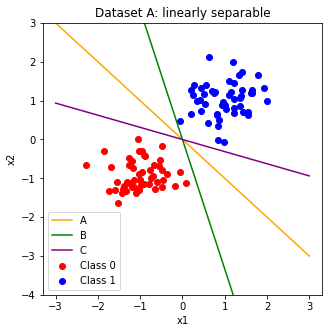

In [7]:
w_A, b_A = [1,1],0
w_B, b_B = [1,0.3],0
w_C, b_C = [0.5,1.6],0
fig, ax = plt.subplots(1,1, figsize=(5,5))

def get_decision_boundary(w,b, X):
    # <w, x> + b = 0
    # x1: x-axis, x2: y-axis -> resolve for x2
    # w1*x1 + w2*x2 + b = 0
    # w2*x2 = -w1*x1 - b
    # x2 = -(w1/w2)*x1 - b/w2
    return -(w[0]/w[1]) * X -(b/w[1])

xfit = np.linspace(-3, 3)
ax.set_ylim(-4,3)
ax.plot(xfit, get_decision_boundary(w_A, b_A, xfit), color="orange", label= "A")
ax.plot(xfit, get_decision_boundary(w_B, b_B, xfit), color="green", label= "B")
ax.plot(xfit, get_decision_boundary(w_C, b_C, xfit), color="purple", label= "C")
plot_dataset(X_blobs1, y_blobs1, title="Dataset A: linearly separable", axes = ax) 


- 1.2 Assume a fourth candidate D shows up with $w=(2,2)$ and $b = 0$. Before you plot it, can you say, if it will be better or worse than the other candidates? Now plot it together with the other candidates, what do you observe?

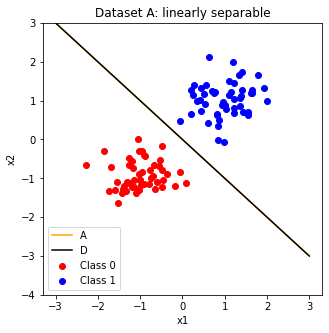

In [8]:
w_D, b_D = [2,2],0
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(xfit, get_decision_boundary(w_A, b_A, xfit), color="orange", label= "A")
ax.plot(xfit, get_decision_boundary(w_D, b_D, xfit), color="black", label= "D")

ax.set_ylim(-4,3)
plot_dataset(X_blobs1, y_blobs1, title="Dataset A: linearly separable", axes = ax)

Remember from the lecture: By definition, the margin and hyperplane are scale invariant. That means classifier and the decision boundary are not unique. For $\gamma>0$ $\tilde{w}=\gamma w$ and $\tilde{b}=\gamma b$ gives the same classifier.

- 1.3 How do we find the best classifier candidate? From the lecture, we know that a maximum margin hyperplane is a hyperplane which correctly classifies the data and has maximum distance/margin to the data. Can you draw around each decision boundary a *margin* with some width up to the nearest point? What do you observe?



[None, None, None]

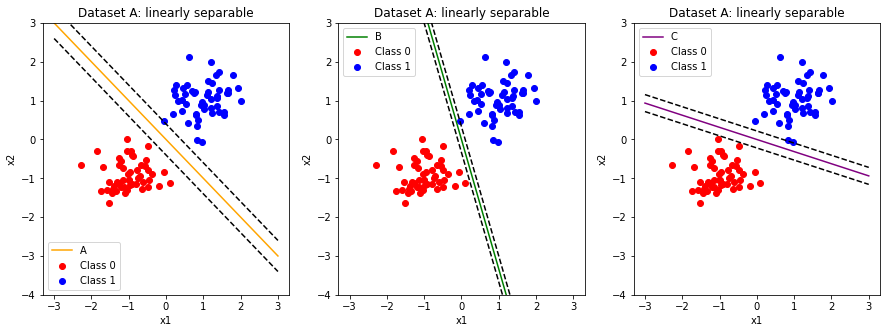

In [9]:
fig, ax = plt.subplots(1,3, figsize=(15,5))


ax[0].plot(xfit, get_decision_boundary(w_A, b_A, xfit), color="orange", label= "A")
ax[0].plot(xfit,get_decision_boundary(w_A, b_A+0.4, xfit), color="black", linestyle='dashed')
ax[0].plot(xfit,get_decision_boundary(w_A, b_A-0.4, xfit), color="black", linestyle='dashed')


ax[1].plot(xfit, get_decision_boundary(w_B, b_B, xfit), color="green", label= "B")
ax[1].plot(xfit,get_decision_boundary(w_B, b_B+0.1, xfit), color="black", linestyle='dashed')
ax[1].plot(xfit,get_decision_boundary(w_B, b_B-0.1, xfit), color="black", linestyle='dashed')

ax[2].plot(xfit, get_decision_boundary(w_C, b_C, xfit), color="purple", label= "C")
ax[2].plot(xfit,get_decision_boundary(w_C, b_C+0.35, xfit), color="black", linestyle='dashed')
ax[2].plot(xfit,get_decision_boundary(w_C, b_C-0.35, xfit), color="black", linestyle='dashed')

[ax[i].set_ylim(-4,3) for i in range(3)]
[plot_dataset(X_blobs1, y_blobs1, title="Dataset A: linearly separable", axes = ax[i]) for i in range(3)]


- 1.4 Lets compute the test error of each hyperplane. Define first a function `clf_predict` that predicts the decisions for a given classifier: $\hat{y}({x})=\operatorname{sign}(\langle{w}, {x}\rangle+b)$. The function takes as input weight $w$ and bias $b$ of the hyperplane and features `X`. Use the `test_error` function you defined above to compute the test error for Classifiers A, B and C. Are the results in line with your observation?

In [10]:
def clf_predict(w,b,X): # returns 0, 1 
    # The sign function returns -1 if x < 0, 0 if x==0, 1 if x > 0.
    # here @ is used as operator __matmul__, because it is designed to do matrix multiplication 
    # https://www.python.org/dev/peps/pep-0465/
    # transpose with reshape(-1, 1)
    return (np.sign(X @ np.array(w).reshape(-1,1) + b)+1)/2

In [11]:
print("Test error A: %.3f" % test_error(clf_predict(w_A,b_A,X_blobs1_test), y_blobs1_test.reshape(-1,1)))
print("Test error B: %.3f" % test_error(clf_predict(w_B,b_B,X_blobs1_test), y_blobs1_test.reshape(-1,1)))
print("Test error C: %.3f" % test_error(clf_predict(w_C,b_C,X_blobs1_test), y_blobs1_test.reshape(-1,1)))

Test error A: 0.002
Test error B: 0.004
Test error C: 0.003


## Hard-margin Support Vector Machine
We formalize a hard-margin SVM as
\begin{array}{l}
\min _{w \in \mathbb{R}^{d}, b \in \mathbb{R}} \frac{1}{2}\|w\|^{2} \\
\text { subject to: } y_{i}\left(\left\langle w, x_{i}\right\rangle+b\right) \geq 1, \quad \forall i=1, \ldots, n
\end{array}

The support vectors are the points on the margin, that is $\langle w, x\rangle+b=\pm 1$.The area between the two supporting hyperplanes $\{x \mid\langle w, x\rangle+b=1\}$ and $\{x \mid\langle w, x\rangle+b=-1\}$ is called the margin.  

- 1.5 Analyze the performance of a linear SVM. For simplicity you can use [this](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) model. Use a default value of `C=1000`. Compute the test error and plot the classification boundary. How many support vectors do you find? Can you print them out?

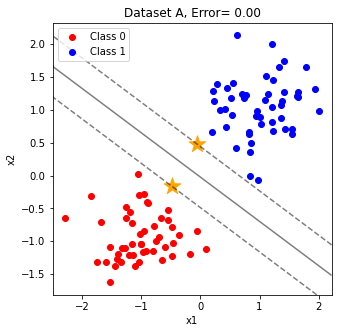

In [12]:
from sklearn.svm import SVC
fig, ax = plt.subplots(1,1, figsize=(5,5))
model = SVC(kernel='linear', C=1000).fit(X_blobs1,y_blobs1)
error = test_error(model.predict(X_blobs1_test),y_blobs1_test)
plot_dataset(X_blobs1, y_blobs1,title="Dataset A, Error= %.2f"%error, axes = ax)
plot_svc_decision_function(model, ax = ax)

1.6 In the lecture, we learned that modifications of the training points matter only if they fall into the margin / or on the wrong side of the decision boundary. Lets try that. Let us use dataset A. Find a datapoint for each of the following cases and augment the the dataset A with the datapoint. Analyze the performance of a linear SVM with `C=1000` on both the original and the augmented dataset. Compute the test error and plot the classification boundary with the support vectors.
- POINT A: correctly classified, outside margin
- POINT B: exactly on margin
- POINT C: correctly classified, inside margin
- POINT D: misclassified, inside margin
- POINT E: misclassified, outside margin

In [13]:
# Original dataset
model_O = SVC(kernel='linear', C=1000).fit(X_blobs1,y_blobs1)
error_O = test_error(model.predict(X_blobs1_test),y_blobs1_test)

In [14]:
# POINT A: correctly classified, outside margin
pt_A = np.array([-3,1]) 
X_blobs1_A = np.concatenate((X_blobs1,pt_A.reshape(1,-1)))
y_blobs1_A = np.concatenate((y_blobs1,np.array([0]))) # class 0

# fit model on augmented dataset
model_A = SVC(kernel='linear', C=1000).fit(X_blobs1_A,y_blobs1_A)
error_A = test_error(model.predict(X_blobs1_test),y_blobs1_test)

# POINT B: exactly on margin
pt_B = np.array([-2,1])
X_blobs1_B = np.concatenate((X_blobs1,pt_B.reshape(1,-1)))
y_blobs1_B = np.concatenate((y_blobs1,np.array([0]))) # class 0

# fit model on augmented dataset
model_B = SVC(kernel='linear', C=1000).fit(X_blobs1_B,y_blobs1_B)
error_B = test_error(model_B.predict(X_blobs1_test),y_blobs1_test)

# POINT C: correctly classified, inside margin
pt_C = np.array([-1.5,1])
X_blobs1_C = np.concatenate((X_blobs1,pt_C.reshape(1,-1)))
y_blobs1_C = np.concatenate((y_blobs1,np.array([0])))

# fit model on augmented dataset
model_C = SVC(kernel='linear', C=1000).fit(X_blobs1_C,y_blobs1_C)
error_C = test_error(model.predict(X_blobs1_test),y_blobs1_test)

# POINT D: misclassified, inside margin
pt_D = np.array([-0.5,1])
X_blobs1_D = np.concatenate((X_blobs1,pt_D.reshape(1,-1)))
y_blobs1_D = np.concatenate((y_blobs1,np.array([0])))

# fit model on augmented dataset
model_D = SVC(kernel='linear', C=1000).fit(X_blobs1_D,y_blobs1_D)
error_D = test_error(model.predict(X_blobs1_test),y_blobs1_test)

# POINT E: misclassified, outside margin
pt_E = np.array([0,1])
X_blobs1_E = np.concatenate((X_blobs1,pt_E.reshape(1,-1)))
y_blobs1_E = np.concatenate((y_blobs1,np.array([0])))

# fit model on augmented dataset
model_E = SVC(kernel='linear', C=1000).fit(X_blobs1_E,y_blobs1_E)
error_E = test_error(model.predict(X_blobs1_test),y_blobs1_test)


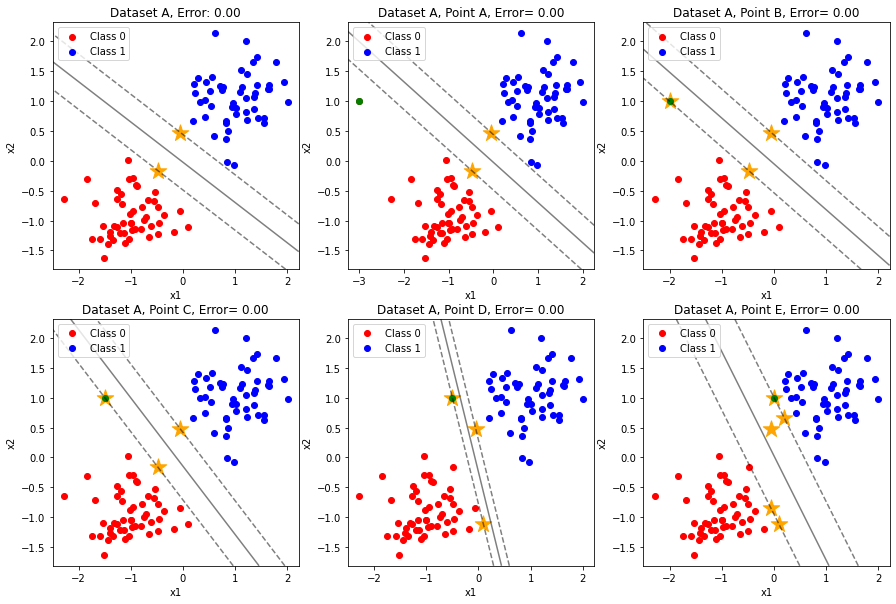

In [15]:
# plot
fig, axes = plt.subplots(2,3, figsize=(15,10))

plot_dataset(X_blobs1, y_blobs1,title="Dataset A, Error: %.2f"%error_O, axes = axes[0][0])
plot_dataset(X_blobs1_A, y_blobs1_A,title="Dataset A, Point A, Error= %.2f"%error_A, axes = axes[0][1])
plot_dataset(X_blobs1_B, y_blobs1_B,title="Dataset A, Point B, Error= %.2f"%error_B, axes = axes[0][2])
plot_dataset(X_blobs1_C, y_blobs1_C,title="Dataset A, Point C, Error= %.2f"%error_C, axes = axes[1][0])
plot_dataset(X_blobs1_D, y_blobs1_D,title="Dataset A, Point D, Error= %.2f"%error_D, axes = axes[1][1])
plot_dataset(X_blobs1_E, y_blobs1_E,title="Dataset A, Point E, Error= %.2f"%error_D, axes = axes[1][2])

plot_svc_decision_function(model_O, ax = axes[0][0])
plot_svc_decision_function(model_A, ax = axes[0][1])
plot_svc_decision_function(model_B, ax = axes[0][2])
plot_svc_decision_function(model_C, ax = axes[1][0])
plot_svc_decision_function(model_D, ax = axes[1][1])
plot_svc_decision_function(model_E, ax = axes[1][2])


axes[0][1].scatter(pt_A[0], pt_A[1], color="green")
axes[0][2].scatter(pt_B[0], pt_B[1], color="green")
axes[1][0].scatter(pt_C[0], pt_C[1], color="green")
axes[1][1].scatter(pt_D[0], pt_D[1], color="green")
axes[1][2].scatter(pt_E[0], pt_E[1], color="green")

Note: in the last case, when we add point E, the dataset becomes no longer linearly seperable - the classes overlap. 

# 2. Overlapping Classes
Previously we have defined a hard-margin SVM. We now move to dataset B and explore, why is this problematic and what a soft-margin SVM does.

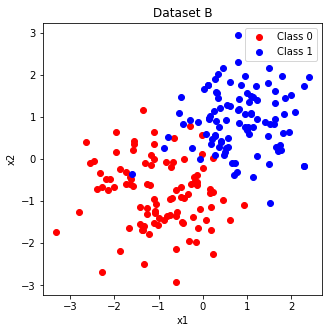

In [16]:
# plot original dataset
fig, ax = plt.subplots(1,1,figsize=(5,5))
plot_dataset(X_blobs2, y_blobs2,title="Dataset B", axes = ax)

## Soft-margin Support Vector Machine
We formalize a soft-margin SVM as
$$
\begin{aligned}
\min _{\mathbf{w} \in \mathbb{R}^{d}, b \in \mathbb{R}, \boldsymbol{\xi} \in \mathbb{R}^{n}} & \frac{1}{2}\|\mathbf{w}\|^{2}+\frac{C}{n} \sum_{i=1}^{n} \xi_{i} \\
\text { subject to: } & Y_{i}\left(\left\langle\mathbf{w}, \mathrm{x}_{i}\right\rangle+b\right) \geq 1-\xi_{i}, \quad \forall i=1, \ldots, n, \\
& \xi_{i} \geq 0, \quad \forall i=1, \ldots, n
\end{aligned}
$$



Therefore, an SVM is trying two things simultaneously: to find a hyperplane with the largest minimum margin, and a hyperplane that correctly separates as many instances as possible. Its a trade-off. The parameter C allows you to determine how much you value the second goal.

- 1.7 What is the functionality of parameter `C`? Why did we choose in the previous example `C=1000`? Explore different values of the `C` parameter `[0.001, 0.01, 1, 10, 100, 1000]` for a linear SVM. Compute the test error and plot the classification boundary for each parameter value. Why did we not include `C=0`?

- `C`: trades off correct classification of training examples against maximization of the decision function’s margin.  A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. A larger C will accept a smaller margin, if the decision function is better at classifying all training points correctly. In other words C behaves as a regularization parameter in the SVM.

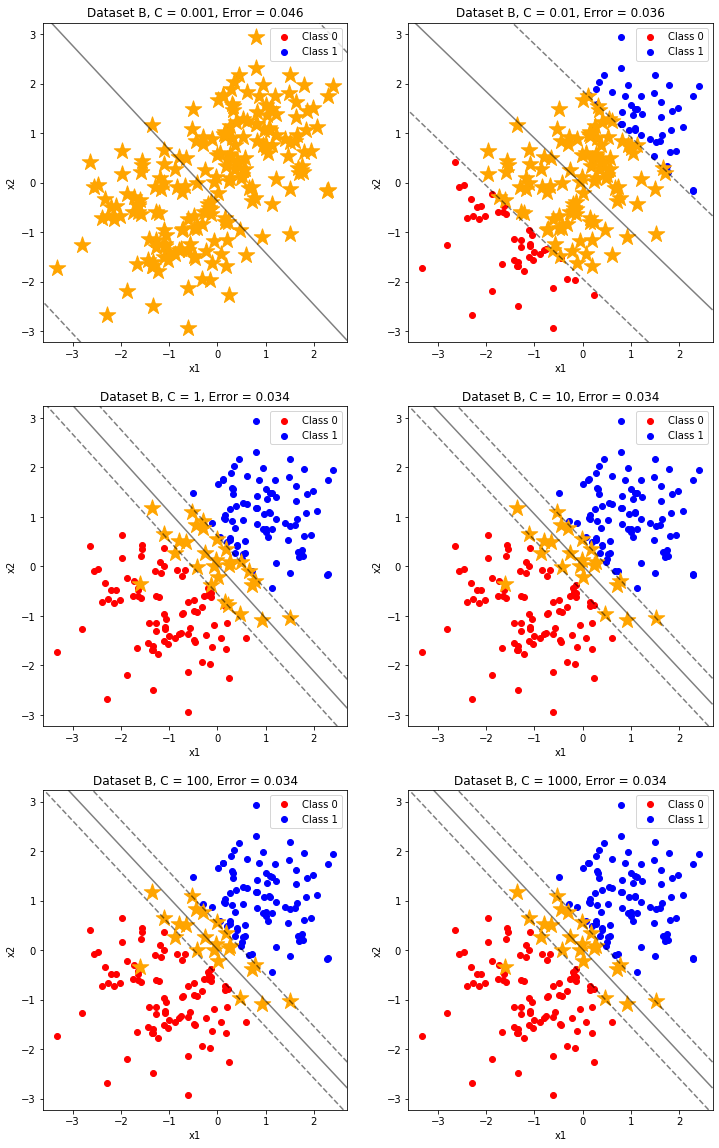

In [17]:
# plot different SVC
fig, axes = plt.subplots(3,2,figsize=(12,20))
for i,c in enumerate([0.001, 0.01, 1, 10, 100, 1000]):
    model = SVC(kernel='linear', C=c).fit(X_blobs2,y_blobs2)
    error = test_error(model.predict(X_blobs2_test),y_blobs2_test)
    plot_dataset(X_blobs2, y_blobs2,title="Dataset B, C = {}, Error = {}".format(c,error), axes = axes[i//2][i % 2])
    plot_svc_decision_function(model, ax = axes[i // 2][i % 2])

In the first plot, we chose a small C, which gave us a pretty large minimum margin. However, this came at the costs of a higher error as we failed to classify a larger number of points correct. As we increase C, we classifier more correctly and end with a much smaller margin.

# 3. Non-linear problems
Until now, we have seen linear separable and non-separable problems. We solved with a linear SVM with a soft margin. A linear SVM uses a kernel: $\left\langle x, x^{\prime}\right\rangle$. We now move to dataset C and non-linear problems. 

- 3.1 Analyze the performance of a linear SVM with value `C = 10000` on dataset C. Compute the test error and plot the classification boundary and support vectors. What do you observe?

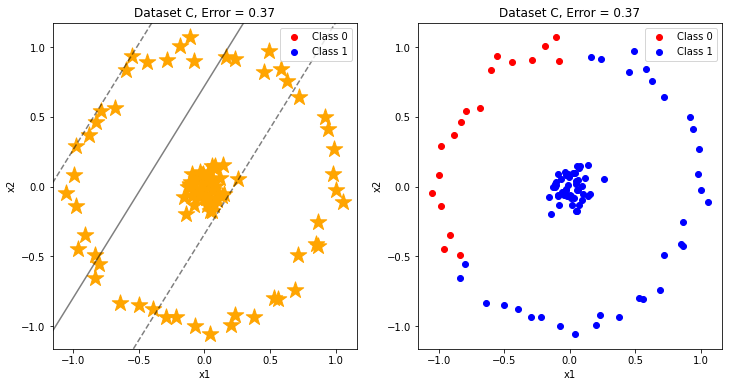

In [18]:
fig, axes = plt.subplots(1,2,figsize=(12,6))
model = SVC(kernel='linear', C=10000).fit(X_circles, y_circles)
error = test_error(model.predict(X_blobs2_test),y_blobs2_test)
plot_dataset(X_circles, model.predict(X_circles),title="Dataset C, Error = %.2f"%error, axes = axes[0])
plot_dataset(X_circles, model.predict(X_circles),title="Dataset C, Error = %.2f"%error, axes = axes[1])
plot_svc_decision_function(model, ax = axes[0])


## Radial Basis Function (RBF) Kernel
We can use an SVM for non-linear problems by choosing a kernel that fits to our data. The radial basis function (RBF) kernel is defined as $$\exp \left(-\gamma\left\|x-x^{\prime}\right\|^{2}\right),$$ where $\gamma$ is specified by parameter gamma and must be greater than 0.

- 3.2  Before we move to solving this non-linear problem with an SVM, lets compute a radial basis function centered on the middle clump: `r = np.exp(-(X ** 2).sum(1))`. Visualize this extra data dimension using a three-dimensional plot. HINT: Running the notebook live, you will be able to rotate the plot.

In [19]:
# Enabling the `widget` backend.
# This requires jupyter-matplotlib a.k.a. ipympl.
# ipympl can be install via pip or conda.
%matplotlib widget

t = lambda x,y:  (np.exp(-1*(np.square(x) + np.square(y)))).reshape(-1,1) 
X_t = t(X_circles[:,0], X_circles[:,1])
X_transformed = np.concatenate( (X_circles,X_t), axis=1)
red = y_circles == 0
blue = y_circles == 1

fig = plt.figure(figsize=(10,5))
ax2 = fig.add_subplot(111, projection='3d')

ax2.scatter3D(X_transformed[red,0], X_transformed[red,1], X_transformed[red,2], color="red", label = "Class 0")
ax2.scatter(X_transformed[blue,0], X_transformed[blue,1], X_transformed[blue,2], color="blue", label = "Class 1")
ax2.set_xlabel("x1")
ax2.set_ylabel("x2")
ax2.set_zlabel("z")
ax2.set_title("Transformed")
ax2.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

- 3.3 Train a no-linear SVM with a RBF kernel. Set `C=1` and explore different values of the `gamma` parameter `[0.01, 0.1, 1, 10, 100]`. Compute the test error and plot the classification boundary. Set `gamma=1` and explore different values of the `C` parameter `[0.01, 0.1, 1, 10, 100]`. Compute the test error and plot the classification boundary. - What does a parameter `C<0`, `C=0` and `C>1` mean?

- `C`: trades off correct classification of training examples against maximization of the decision function’s margin.  A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. A larger C will accept a smaller margin, if the decision function is better at classifying all training points correctly. In other words C behaves as a regularization parameter in the SVM.


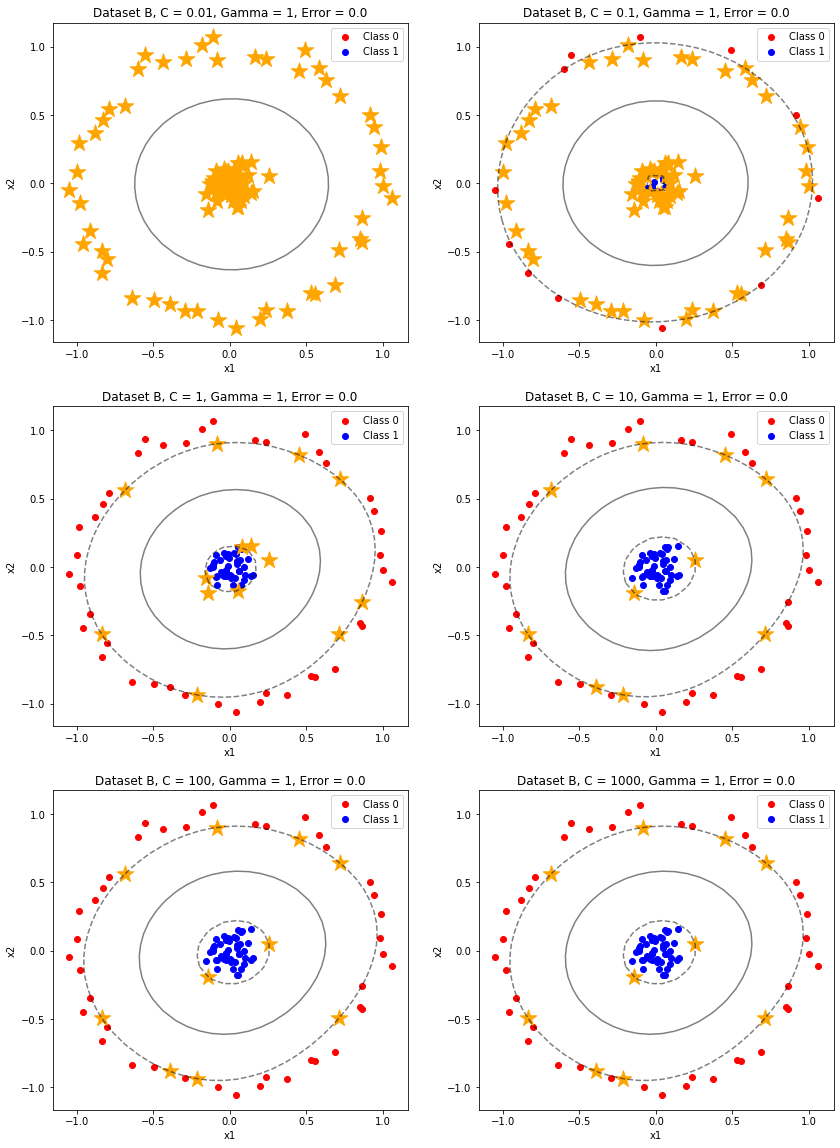

In [20]:
%matplotlib inline
# sweep over C
fig, axes = plt.subplots(3,2,figsize=(14,20))
for i,C in enumerate([0.01, 0.1, 1, 10, 100, 1000]):
    model = SVC(kernel='rbf', C=C, gamma=1 ).fit(X_circles, y_circles)
    error = test_error(model.predict(X_circles_test),y_circles_test)
    plot_dataset(X_circles, y_circles,title="Dataset B, C = {}, Gamma = 1, Error = {}".format(C,error), axes = axes[i//2][i % 2])
    plot_svc_decision_function(model, ax = axes[i // 2][i % 2])

- `gamma`: defines how far the influence of a single training example reaches. The gamma parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors. A low value means a large radius of influence (the ‘curve’ of the decision boundary is very low, thus the decision region is very broad). A high value means a small radius of influence (the ‘curve’ of the decision boundary is very high, thus we get islands of decision-boundaries around data points). More on this can be read [here](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py).

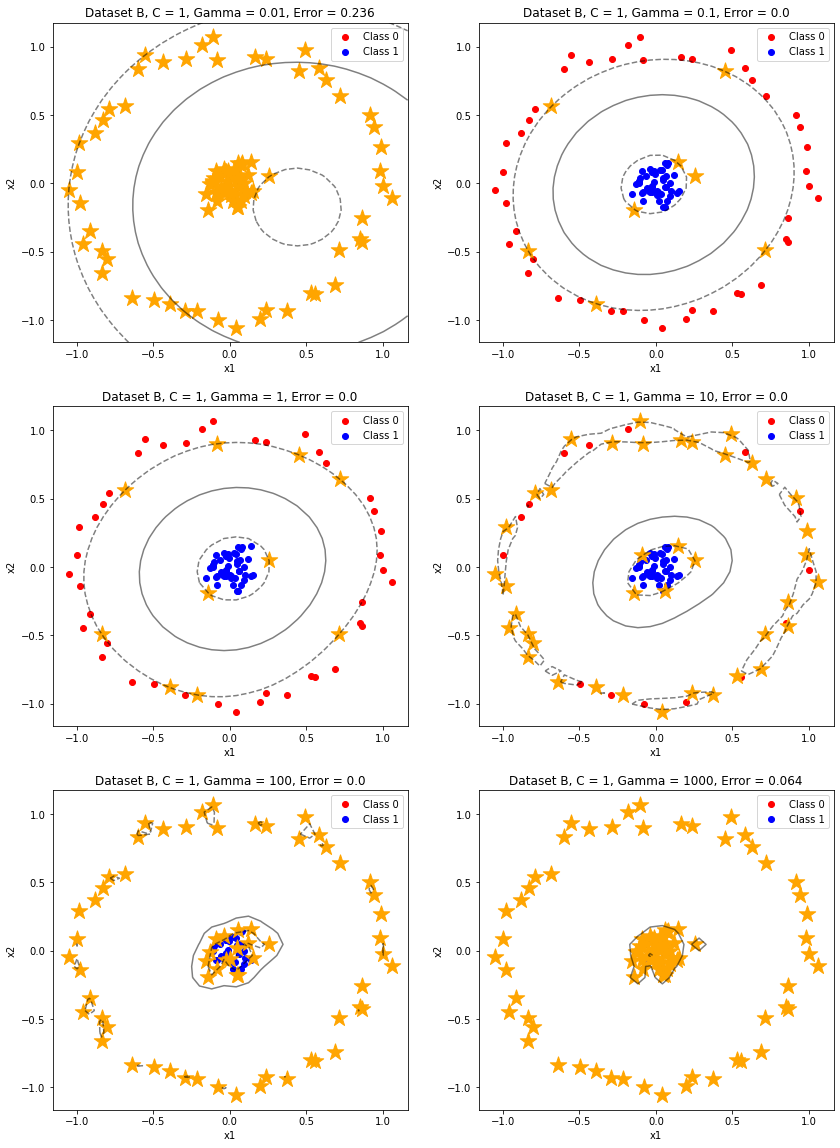

In [21]:
%matplotlib inline
# sweep over gamma
fig, axes = plt.subplots(3,2,figsize=(14,20))
for i,gamma in enumerate([0.01, 0.1, 1, 10, 100, 1000]):
    model = SVC(kernel='rbf', C=100, gamma=gamma ).fit(X_circles, y_circles)
    error = test_error(model.predict(X_circles_test),y_circles_test)
    plot_dataset(X_circles, y_circles,title="Dataset B, C = 1, Gamma = {}, Error = {}".format(gamma,error), axes = axes[i//2][i % 2])
    plot_svc_decision_function(model, ax = axes[i // 2][i % 2])

# 4. Choosing Parameters
One of the limitations of SVMs is that there is the complexity parameter `C` - and for non-linear kernels a parameter previously called `gamma` - that must be found using a hold-out method such as cross-validation (CV). Lets take a look at this together.
- Use a 5-fold CV (via `cross_val_score`, see [here](https://scikit-learn.org/stable/modules/cross_validation.html)) to adjust both `C` and `gamma` parameters of a RBF SVM for not linearly seperable data. Explore values of `C` in `[0.01, 0.01, 0.1, 1, 10, 100, 1000]`, and define the range of `gamma` as: `[0.125, 0.25, 0.5, 1, 2, 4, 8])/D`, being `D` the data dimension. Note that this definition of the `gamma` values is used alleviate the influence of the data dimension in the definition of the RBF kernel. Print mean and standard deviation of the scores. Which model provides you the best results? 

In [22]:
# Note, to import terminaltables here, you will need to install it in your environment.
# If you use conda, try: conda install -c conda-forge terminaltables
import terminaltables
from IPython.display import display, Markdown

In [23]:
C = [0.01, 0.01, 0.1, 1, 10, 100, 1000]
gamma = [0.125/2, 0.25/2, 0.5/2, 1/2, 2/2, 4/2, 8/2]
table_content = [["C \ gamma",*gamma]]
for c in C:
    temp = [c]
    for gamma in np.array([0.125, 0.25, 0.5, 1, 2, 4, 8])/2:
        clf = SVC(kernel='rbf', C=c,gamma = gamma)
        scores = cross_val_score(clf, X_circles,y_circles, cv=5)
        temp.append( str(round(scores.mean(),3)) + "&#xB1;" + str(round(scores.std(),3)))
    table_content.append(temp)

In [24]:
table = terminaltables.GithubFlavoredMarkdownTable(table_content)
display(Markdown(table.table))

| C \ gamma | 0.0625         | 0.125           | 0.25           | 0.5          | 1.0          | 2.0          | 4.0          |
|-----------|----------------|-----------------|----------------|--------------|--------------|--------------|--------------|
| 0.01      | 0.7&#xB1;0.095 | 0.84&#xB1;0.139 | 0.97&#xB1;0.06 | 1.0&#xB1;0.0 | 1.0&#xB1;0.0 | 1.0&#xB1;0.0 | 1.0&#xB1;0.0 |
| 0.01      | 0.7&#xB1;0.095 | 0.84&#xB1;0.139 | 0.97&#xB1;0.06 | 1.0&#xB1;0.0 | 1.0&#xB1;0.0 | 1.0&#xB1;0.0 | 1.0&#xB1;0.0 |
| 0.1       | 0.7&#xB1;0.095 | 0.84&#xB1;0.139 | 0.97&#xB1;0.06 | 1.0&#xB1;0.0 | 1.0&#xB1;0.0 | 1.0&#xB1;0.0 | 1.0&#xB1;0.0 |
| 1         | 0.7&#xB1;0.095 | 0.84&#xB1;0.139 | 1.0&#xB1;0.0   | 1.0&#xB1;0.0 | 1.0&#xB1;0.0 | 1.0&#xB1;0.0 | 1.0&#xB1;0.0 |
| 10        | 1.0&#xB1;0.0   | 1.0&#xB1;0.0    | 1.0&#xB1;0.0   | 1.0&#xB1;0.0 | 1.0&#xB1;0.0 | 1.0&#xB1;0.0 | 1.0&#xB1;0.0 |
| 100       | 1.0&#xB1;0.0   | 1.0&#xB1;0.0    | 1.0&#xB1;0.0   | 1.0&#xB1;0.0 | 1.0&#xB1;0.0 | 1.0&#xB1;0.0 | 1.0&#xB1;0.0 |
| 1000      | 1.0&#xB1;0.0   | 1.0&#xB1;0.0    | 1.0&#xB1;0.0   | 1.0&#xB1;0.0 | 1.0&#xB1;0.0 | 1.0&#xB1;0.0 | 1.0&#xB1;0.0 |

HINT: For further information on the parameters and their trade-off, take a look [here](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html).

# 5. Different Kernels, Multiple Classes 
In addition to the linear and RBF kernel, scikit-learn also implements e.g. the following kernels
- polynomial: $\left(\gamma\left\langle x, x^{\prime}\right\rangle+r\right)^{d}$, where $d$ is specified by parameter `degree`, $r$ by `coef0`.
-  sigmoid: $\tanh \left(\gamma\left\langle x, x^{\prime}\right\rangle+r\right)$,  where  $r$  is specified by `coef0`.

We will take a brief look at what how their decision boundaries look like.

- Lets move to a multi-class dataset D and take a look at the decision boundaries of the different kernels. Analyze the performance of an SVM with `linear`, `rbf`(gamma=0.7),`poly`(with `degree=3`, `gamma='auto'`) and `sigmoid`(`gamma='auto'`) kernels. For the sake of simplicity, you can use a default value of `C = 1`. Compute the test error and plot the classification boundary. What does the gamma mean for each of the kernels? 

In [25]:
# from here: https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html

def make_meshgrid(x, y, h=.02):
    # Create a mesh of points to plot in
    # from 
    
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    #Plot the decision boundaries for a classifier.
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


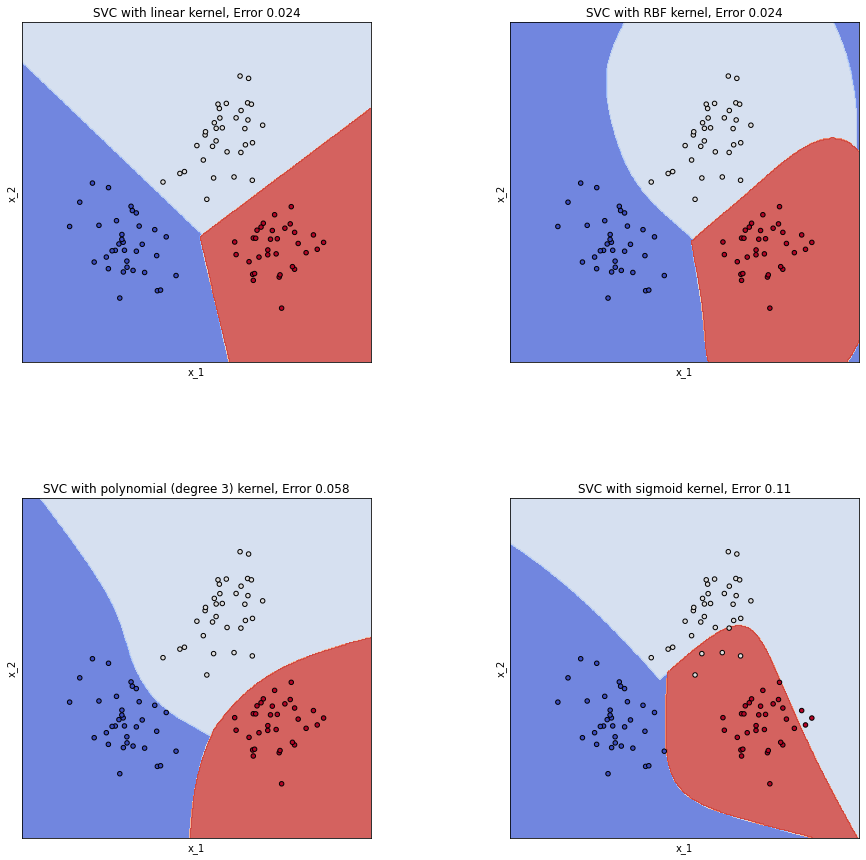

In [26]:
C = 1.0  # SVM regularization parameter

models = []
models.append(SVC(kernel='linear', C=C))
models.append(SVC(kernel='rbf', gamma=0.7, C=C))
models.append(SVC(kernel='poly', degree=3, gamma='auto', C=C))
models.append(SVC(kernel='sigmoid',  gamma='auto', C=C))

clfs = []
err_list = []
for clf in models:
    clf.fit(X_blobs3, y_blobs3)
    clfs.append(clf)
    score = test_error(y_blobs3_test,clf.predict(X_blobs3_test))
    err_list.append(score)


titles = ('SVC with linear kernel',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel',
          'SVC with sigmoid kernel')

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2,figsize=(15,15))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X_blobs3[:, 0], X_blobs3[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, er, ax in zip(models, titles, err_list, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y_blobs3, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title + ", Error " + str(er))

plt.show()



HINT: Not enough kernels to choose from? Interested in a DIY-kernel? Check [this](https://scikit-learn.org/stable/auto_examples/svm/plot_custom_kernel.html#sphx-glr-auto-examples-svm-plot-custom-kernel-py) out.

# 6. Further Considerations (self-study)
The following considerations are not study focus of this notebook. 
- unbalanced classes: [here](https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html#sphx-glr-auto-examples-svm-plot-separating-hyperplane-unbalanced-py)
- weighted samples: [here](https://scikit-learn.org/stable/auto_examples/svm/plot_weighted_samples.html#sphx-glr-auto-examples-svm-plot-weighted-samples-py)
- one-versus-rest multi-class approach: [here](https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html#sphx-glr-auto-examples-svm-plot-iris-svc-py)
- SVMs on hand written digits: [here](https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html)
- SVMs with different kernels vs. Logistic Regression: [here](https://dmkothari.github.io/Machine-Learning-Projects/SVM_with_MNIST.html)
- SVMs vs Neural Nets (NN) [here](https://www.researchgate.net/post/Which-is-more-accurate-Neural-Networks-NNsor-support-vector-machineSVM)